# Dataset Creation

For Our Project we will create the following datasets
- True Balanced Test Set (Mimicking a real world scenario: No model sees this)
- Balanced Dataset (To test baseline)
- Caucasian Biased Dataset (Data gathered in an affluent area)
- Caucasian Biased Dataset + SMOTE (Artificial Upsampling of other races)
- Asian Biased Dataset
- Asian Biased Dataset + SMOTE


# True Balanced Test Set

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("diabetes_cleaned.csv")

In [3]:
df.head()

,age,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,gender_Male,race
0,32.0,0,0,27.32,5.0,100,0,0,Other
1,29.0,0,0,19.95,5.0,90,0,0,Asian
2,18.0,0,0,23.76,4.8,160,0,1,Other
3,41.0,0,0,27.32,4.0,159,0,1,Caucasian
4,52.0,0,0,23.75,6.5,90,0,0,AfricanAmerican


In [4]:
x = df.drop("diabetes", axis=1)
y = df["diabetes"]
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.3, random_state=42
)


print("x_train shape:", xtrain.shape)
print("x_test shape:", xtest.shape)
print("y_train shape:", ytrain.shape)
print("y_test shape:", ytest.shape)


x_train shape: (69987, 8)
x_test shape: (29995, 8)
y_train shape: (69987,)
y_test shape: (29995,)


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Hispanic'),
  Text(1, 0, 'AfricanAmerican'),
  Text(2, 0, 'Caucasian'),
  Text(3, 0, 'Asian'),
  Text(4, 0, 'Other')])

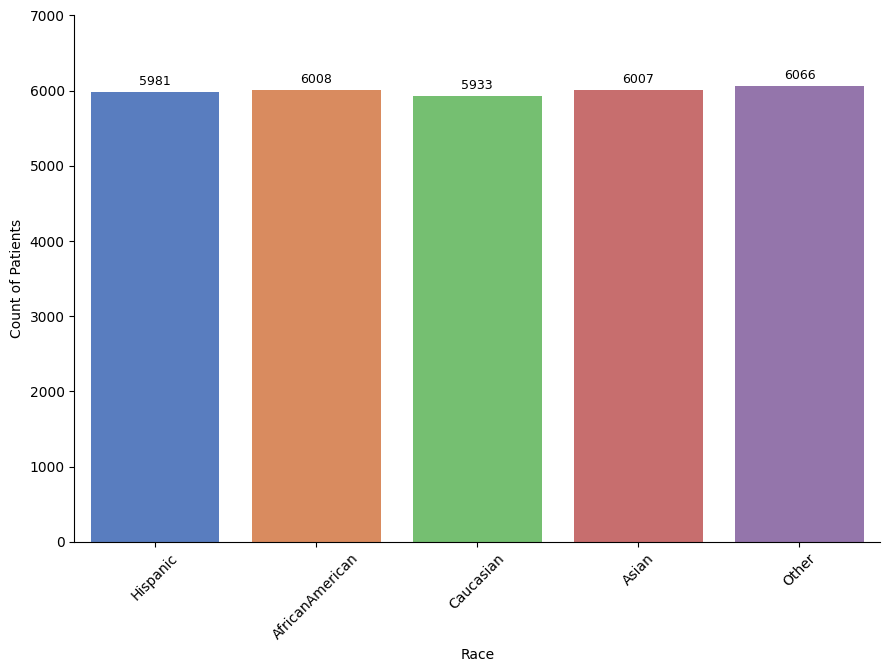

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' and 'diabetes' columns are correctly defined in your environment
# race_columns is not directly used in the plotting code, but kept for context
race_columns = [
    'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 
    'race:Hispanic', 'race:Other'
]

# Create the plot
g = sns.catplot(
    data=xtest,
    x='race',          # Put Race on the X-axis
    # Group bars by Diabetes status (this creates the side-by-side look)
    kind='count',      # Count the number of people
    height=6,
    aspect=1.5,
    palette='muted'    # Optional: Makes the colors look nicer
)

# --- Code to add counts on top of bars ---
# Get the single axes object from the FacetGrid
ax = g.axes.flat[0]

# Iterate through the bar containers and add annotations
for container in ax.containers:
    # container is a PatchCollection (a set of bars for one hue group)
    for p in container.patches:
        height = p.get_height()
        # Only annotate if the height (count) is greater than zero
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2., # x-position: center of the bar
                height + 50,                    # y-position: a little above the top of the bar
                f'{height:.0f}',                # The count value (formatted as integer)
                ha='center',                    # Horizontal alignment: center
                va='bottom',                    # Vertical alignment: bottom
                fontsize=9                      # Smaller font size for clarity
            )

g.set_axis_labels("Race", "Count of Patients")
# Adjust y-axis limit to make room for the annotations at the top of the tallest bar
# You may need to manually adjust this based on your maximum count
ax.set_ylim(top=ax.get_ylim()[1] * 1.1) 
# ----------------------------------------
plt.xticks(rotation=45)

In [6]:
# Since this is balanced, we will save this to a csv with the true labels
xtest.to_csv("final_holdout_x.csv", index=False)
ytest.to_csv("final_holdout_y.csv", index=False)

xtrain.to_csv("X.csv", index=False)
ytrain.to_csv("y.csv", index=False)

# Baseline Balanced Dataset

In [7]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

xtrain,xtest,ytrain,ytest = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print("x_train shape:", xtrain.shape)
print("x_test shape:", xtest.shape)
print("y_train shape:", ytrain.shape)
print("y_test shape:", ytest.shape)

xtrain.to_csv("balanced_xtrain.csv", index=False)
ytrain.to_csv("balanced_ytrain.csv", index=False)
xtest.to_csv("balanced_xtest.csv", index=False)
ytest.to_csv("balanced_ytest.csv", index=False)

x_train shape: (48990, 8)
x_test shape: (20997, 8)
y_train shape: (48990, 1)
y_test shape: (20997, 1)


# Caucasian Biased Dataset

In [8]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69987 entries, 0 to 69986
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  69987 non-null  float64
 1   hypertension         69987 non-null  int64  
 2   heart_disease        69987 non-null  int64  
 3   bmi                  69987 non-null  float64
 4   hbA1c_level          69987 non-null  float64
 5   blood_glucose_level  69987 non-null  int64  
 6   gender_Male          69987 non-null  int64  
 7   race                 69987 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 4.3+ MB


In [10]:
X['race'].unique()

array(['Caucasian', 'Hispanic', 'Other', 'AfricanAmerican', 'Asian'],
      dtype=object)

In [11]:
import pandas as pd
import numpy as np

# Assume X and y are your original feature and label datasets

# --- 1. Define Target Proportions and Feasibility Check ---

# Define the desired proportions for each race
target_proportions = {
    'Caucasian': 0.700,
    'Hispanic': 0.075,
    'Other': 0.075,
    'AfricanAmerican': 0.075,
    'Asian': 0.075
}

# Get the actual counts in your original dataset
actual_counts = X['race'].value_counts()
print(f"Original counts:\n{actual_counts}")
print("-" * 30)

# Start with a very large number for the maximum possible total sample size
max_feasible_N_total = float('inf')
most_constrained_race = ""

# Iterate through all races to find the TRUE bottleneck
for race, prop in target_proportions.items():
    available_count = actual_counts.get(race, 0)
    
    # Calculate the maximum possible N_total if this race group were the only constraint
    max_N_for_this_race = available_count / prop
    
    if max_N_for_this_race < max_feasible_N_total:
        max_feasible_N_total = max_N_for_this_race
        most_constrained_race = race

# Finalize the total sample size (use floor/int to ensure it's a whole number)
N_total_final = int(np.floor(max_feasible_N_total))

print(f"✅ The MOST constrained group is: '{most_constrained_race}'")
print(f"✅ The MAXIMUM feasible total sample size is: {N_total_final}")
print("-" * 30)


# --- 2. Calculate Final Target Counts ---

# Recalculate target_counts with the new, guaranteed feasible N_total
target_counts = {}
for race, prop in target_proportions.items():
    # Use floor/int to ensure the count is not higher than available
    target_counts[race] = int(np.floor(prop * N_total_final))

print(f"Final target counts for sampling: {target_counts}")
print("-" * 30)

# --- 3. Perform Stratified Sampling and Capture Indices ---

# Group the original DataFrame by 'race'
grouped = X.groupby('race')

# Sample from each group and store in a list
sampled_data = []
for race, count in target_counts.items():
    if count > 0:
        # This sampling will now succeed because 'count' is guaranteed to be <= available rows
        sample = grouped.get_group(race).sample(n=count, random_state=42, replace=False)
        sampled_data.append(sample)

# Concatenate all the sampled DataFrames *without* resetting the index yet
X_temp = pd.concat(sampled_data)

# >>> CRUCIAL STEP 1: Extract the original index <<<
biased_indices = X_temp.index

# >>> CRUCIAL STEP 2: Create X_biased with the new sequential index <<<
X_biased = X_temp.reset_index(drop=True)

# --- 4. Slice the Label Data (y) ---

# Slice the label data using the original indices
y_biased = y.loc[biased_indices]

print(f"X_biased shape: {X_biased.shape}")
print(f"y_biased shape: {y_biased.shape}")

X_biased.to_csv("X_caucasian_biased.csv", index=False)
y_biased.to_csv("y_caucasian_biased.csv", index=False)

Original counts:
race
AfricanAmerican    14213
Asian              14006
Caucasian          13934
Other              13930
Hispanic           13904
Name: count, dtype: int64
------------------------------
✅ The MOST constrained group is: 'Caucasian'
✅ The MAXIMUM feasible total sample size is: 19905
------------------------------
Final target counts for sampling: {'Caucasian': 13933, 'Hispanic': 1492, 'Other': 1492, 'AfricanAmerican': 1492, 'Asian': 1492}
------------------------------
X_biased shape: (19901, 8)
y_biased shape: (19901, 1)


# Caucasian Biased Dataset + SMOTE

In [12]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
from sklearn.neighbors import NearestNeighbors

# --- 1. Load Data ---
X = pd.read_csv('X_caucasian_biased.csv')
y = pd.read_csv('y_caucasian_biased.csv')
y_label = y.iloc[:, 0].copy() # Actual prediction target (e.g., 'diabetes')

print(f"Original X shape: {X.shape}")
print(f"Original race distribution:\n{X['race'].value_counts()}")
print("-" * 50)

# --- 2. Prepare Data and Strategy ---

# Define the feature being balanced ('race') as the temporary target (y_race)
y_race = X['race']

# The features to be sampled (dropping 'race')
X_features = X.drop(columns=['race'])

# Calculate the count of the majority class ('Caucasian')
majority_class_count = y_race.value_counts().get('Caucasian')

# Define Sampling Strategy: Upsample all minority classes up to the majority count
sampling_strategy = {}
for race in y_race.unique():
    sampling_strategy[race] = majority_class_count

# --- 3. Apply SMOTE to Generate Synthetic Features (X) ---

smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=5, random_state=42)

# X_resampled_features: Features for both original and synthetic samples.
# y_race_resampled: The race label for all samples (including the new ones).
X_resampled_features, y_race_resampled = smote.fit_resample(X_features, y_race)

# Determine which rows are synthetic (i.e., not in the original index)
original_indices = X.index
resampled_indices = X_resampled_features.index

# Identify the synthetic samples (the indices that are NOT in the original index)
synthetic_indices = resampled_indices[~resampled_indices.isin(original_indices)]


# --- 4. Propagate Labels (y) for Synthetic Samples ---

# Initialize the final balanced y (y_balanced) starting with the original y_label
y_balanced = y_label.copy().reset_index(drop=True)

# 4a. Find the indices of the original samples used for generating synthetic data
# We use NearestNeighbors on the original feature set (X_features)
nn = NearestNeighbors(n_neighbors=5).fit(X_features)

# Iterate through the synthetic samples
synthetic_labels = []
for idx in synthetic_indices:
    # Get the feature vector of the synthetic sample
    synthetic_sample = X_resampled_features.loc[idx].values.reshape(1, -1)
    
    # Find the 5 nearest neighbors in the ORIGINAL dataset
    distances, neighbor_indices = nn.kneighbors(synthetic_sample, n_neighbors=5)
    
    # Get the y_label values of those neighbors
    neighbor_y_labels = y_label.iloc[neighbor_indices[0]]
    
    # Assign the MODE of the neighbors' y_labels to the synthetic sample
    # Counter returns the frequency of items; most_common(1)[0][0] gets the mode.
    synthetic_label = Counter(neighbor_y_labels).most_common(1)[0][0]
    synthetic_labels.append(synthetic_label)

# 4b. Concatenate the original y_labels with the new synthetic labels
y_balanced = pd.concat([y_balanced, pd.Series(synthetic_labels)]).reset_index(drop=True)


# --- 5. Finalize X_balanced ---

# Re-attach the race column to the resampled features
X_balanced = X_resampled_features
X_balanced['race'] = y_race_resampled

# --- 6. Verification and Export ---

print(f"Balanced X shape (SMOTE): {X_balanced.shape}")
print(f"Balanced race distribution:\n{X_balanced['race'].value_counts()}")
print("-" * 50)

# Save the balanced datasets
X_balanced.to_csv('X_caucasian_smote.csv', index=False)
y_balanced.to_csv('y_caucasian_smote.csv', index=False, header=[y_label.name])

Original X shape: (19901, 8)
Original race distribution:
race
Caucasian          13933
Hispanic            1492
Other               1492
AfricanAmerican     1492
Asian               1492
Name: count, dtype: int64
--------------------------------------------------
Balanced X shape (SMOTE): (69665, 8)
Balanced race distribution:
race
Caucasian          13933
Hispanic           13933
Other              13933
AfricanAmerican    13933
Asian              13933
Name: count, dtype: int64
--------------------------------------------------


# Asian Biased Dataset

In [13]:
# Assume X and y are your original feature and label datasets
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")
# --- 1. Define Target Proportions and Feasibility Check ---

# Define the desired proportions for each race
target_proportions = {
    'Caucasian': 0.075,
    'Hispanic': 0.075,
    'Other': 0.075,
    'AfricanAmerican': 0.075,
    'Asian': 0.700
}

# Get the actual counts in your original dataset
actual_counts = X['race'].value_counts()
print(f"Original counts:\n{actual_counts}")
print("-" * 30)

# Start with a very large number for the maximum possible total sample size
max_feasible_N_total = float('inf')
most_constrained_race = ""

# Iterate through all races to find the TRUE bottleneck
for race, prop in target_proportions.items():
    available_count = actual_counts.get(race, 0)
    
    # Calculate the maximum possible N_total if this race group were the only constraint
    max_N_for_this_race = available_count / prop
    
    if max_N_for_this_race < max_feasible_N_total:
        max_feasible_N_total = max_N_for_this_race
        most_constrained_race = race

# Finalize the total sample size (use floor/int to ensure it's a whole number)
N_total_final = int(np.floor(max_feasible_N_total))

print(f"✅ The MOST constrained group is: '{most_constrained_race}'")
print(f"✅ The MAXIMUM feasible total sample size is: {N_total_final}")
print("-" * 30)


# --- 2. Calculate Final Target Counts ---

# Recalculate target_counts with the new, guaranteed feasible N_total
target_counts = {}
for race, prop in target_proportions.items():
    # Use floor/int to ensure the count is not higher than available
    target_counts[race] = int(np.floor(prop * N_total_final))

print(f"Final target counts for sampling: {target_counts}")
print("-" * 30)

# --- 3. Perform Stratified Sampling and Capture Indices ---

# Group the original DataFrame by 'race'
grouped = X.groupby('race')

# Sample from each group and store in a list
sampled_data = []
for race, count in target_counts.items():
    if count > 0:
        # This sampling will now succeed because 'count' is guaranteed to be <= available rows
        sample = grouped.get_group(race).sample(n=count, random_state=42, replace=False)
        sampled_data.append(sample)

# Concatenate all the sampled DataFrames *without* resetting the index yet
X_temp = pd.concat(sampled_data)

# >>> CRUCIAL STEP 1: Extract the original index <<<
biased_indices = X_temp.index

# >>> CRUCIAL STEP 2: Create X_biased with the new sequential index <<<
X_biased = X_temp.reset_index(drop=True)

# --- 4. Slice the Label Data (y) ---

# Slice the label data using the original indices
y_biased = y.loc[biased_indices]

print(f"X_biased shape: {X_biased.shape}")
print(f"y_biased shape: {y_biased.shape}")

X_biased.to_csv("X_asian_biased.csv", index=False)
y_biased.to_csv("y_asian_biased.csv", index=False)

Original counts:
race
AfricanAmerican    14213
Asian              14006
Caucasian          13934
Other              13930
Hispanic           13904
Name: count, dtype: int64
------------------------------
✅ The MOST constrained group is: 'Asian'
✅ The MAXIMUM feasible total sample size is: 20008
------------------------------
Final target counts for sampling: {'Caucasian': 1500, 'Hispanic': 1500, 'Other': 1500, 'AfricanAmerican': 1500, 'Asian': 14005}
------------------------------
X_biased shape: (20005, 8)
y_biased shape: (20005, 1)


# Asian Biased Dataset + SMOTE

In [15]:
# --- 1. Load Data ---
X = pd.read_csv('X_asian_biased.csv')
y = pd.read_csv('y_asian_biased.csv')
y_label = y.iloc[:, 0].copy() # Actual prediction target (e.g., 'diabetes')

print(f"Original X shape: {X.shape}")
print(f"Original race distribution:\n{X['race'].value_counts()}")
print("-" * 50)

# --- 2. Prepare Data and Strategy ---

# Define the feature being balanced ('race') as the temporary target (y_race)
y_race = X['race']

# The features to be sampled (dropping 'race')
X_features = X.drop(columns=['race'])

# Calculate the count of the majority class ('Asian')
majority_class_count = y_race.value_counts().get('Asian')

# Define Sampling Strategy: Upsample all minority classes up to the majority count
sampling_strategy = {}
for race in y_race.unique():
    sampling_strategy[race] = majority_class_count

# --- 3. Apply SMOTE to Generate Synthetic Features (X) ---

smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=5, random_state=42)

# X_resampled_features: Features for both original and synthetic samples.
# y_race_resampled: The race label for all samples (including the new ones).
X_resampled_features, y_race_resampled = smote.fit_resample(X_features, y_race)

# Determine which rows are synthetic (i.e., not in the original index)
original_indices = X.index
resampled_indices = X_resampled_features.index

# Identify the synthetic samples (the indices that are NOT in the original index)
synthetic_indices = resampled_indices[~resampled_indices.isin(original_indices)]


# --- 4. Propagate Labels (y) for Synthetic Samples ---

# Initialize the final balanced y (y_balanced) starting with the original y_label
y_balanced = y_label.copy().reset_index(drop=True)

# 4a. Find the indices of the original samples used for generating synthetic data
# We use NearestNeighbors on the original feature set (X_features)
nn = NearestNeighbors(n_neighbors=5).fit(X_features)

# Iterate through the synthetic samples
synthetic_labels = []
for idx in synthetic_indices:
    # Get the feature vector of the synthetic sample
    synthetic_sample = X_resampled_features.loc[idx].values.reshape(1, -1)
    
    # Find the 5 nearest neighbors in the ORIGINAL dataset
    distances, neighbor_indices = nn.kneighbors(synthetic_sample, n_neighbors=5)
    
    # Get the y_label values of those neighbors
    neighbor_y_labels = y_label.iloc[neighbor_indices[0]]
    
    # Assign the MODE of the neighbors' y_labels to the synthetic sample
    # Counter returns the frequency of items; most_common(1)[0][0] gets the mode.
    synthetic_label = Counter(neighbor_y_labels).most_common(1)[0][0]
    synthetic_labels.append(synthetic_label)

# 4b. Concatenate the original y_labels with the new synthetic labels
y_balanced = pd.concat([y_balanced, pd.Series(synthetic_labels)]).reset_index(drop=True)


# --- 5. Finalize X_balanced ---

# Re-attach the race column to the resampled features
X_balanced = X_resampled_features
X_balanced['race'] = y_race_resampled

# --- 6. Verification and Export ---

print(f"Balanced X shape (SMOTE): {X_balanced.shape}")
print(f"Balanced race distribution:\n{X_balanced['race'].value_counts()}")
print("-" * 50)

# Save the balanced datasets
X_balanced.to_csv('X_asian_smote.csv', index=False)
y_balanced.to_csv('y_asian_smote.csv', index=False, header=[y_label.name])

Original X shape: (20005, 8)
Original race distribution:
race
Asian              14005
Caucasian           1500
Hispanic            1500
Other               1500
AfricanAmerican     1500
Name: count, dtype: int64
--------------------------------------------------
Balanced X shape (SMOTE): (70025, 8)
Balanced race distribution:
race
Caucasian          14005
Hispanic           14005
Other              14005
AfricanAmerican    14005
Asian              14005
Name: count, dtype: int64
--------------------------------------------------
